<a href="https://colab.research.google.com/github/Klein225/Option-Pricing-Using-Neural-Networks/blob/master/European_Call_in_Black_%26_Scholes_(McGhee_Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Europen Call in Black-Scholes-Merton (Partially McGhee)**
We will try and learn the BSM Model (without dividends) using a Neural Network with the same (almost) parameters as in McGhees paper "An Artificual Neural Network Representation of the SABR Stochastic Volatility Model". This is intended as a introduction to the more complex SABR model which is an extension of the BSM model.

We will start by creatin a dataset for us to train on

In [0]:
# Import packages
import pylab
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
#N: number of random options
N = 100000

#Make the same random numbers every time using seed
random.seed(42)

#uniform stock pices
S = np.random.rand(N) * 100
#Stike prices (simpler version of how McGhee chooses his strike prices)
K = (np.random.randint(50, 150, N) * .01) * S
#Time (1day to 2 years)
T = np.random.randint(1, 730, N) / 365
#Risk free rate
r = np.random.randint(1, 500, N) / 10000
#volatility (5% to 50%)
sigma = np.random.randint(5, 50, N) / 100

In [0]:
Option_values = pd.DataFrame({'S': S,
                              'K': K,
                              'T': T,
                              'r': r,
                              'sigma': sigma})

In [4]:
Option_values.tail()

,S,K,T,r,sigma
99995,17.501734,14.176405,0.736986,0.0035,0.27
99996,65.691242,35.473270,1.175342,0.0434,0.22
99997,18.919857,18.541460,0.405479,0.0398,0.33
99998,40.290920,31.426918,1.912329,0.0134,0.14
99999,69.016302,66.255650,1.164384,0.0234,0.25


**<h3><center>Black & Scholes' formula</center></h3>**

Since we are using supervised learning, we need to calculate the BSM call prices. this is done using the following formula:
$$
B{S_{K,T,\sigma }}\left( S \right) = SN\left( {\frac{{\log \left( {\frac{S}{K}} \right) +\left( r+ \frac{{{\sigma ^2 T}}}{2}\right)}}{\sigma \sqrt{T} }} \right) - KN\left( {\frac{{\log \left( {\frac{S}{K}} \right) +\left( r- \frac{{{\sigma ^2 T}}}{2}\right)}}{\sigma\sqrt{T} }} \right)
$$

In [0]:
def bsm_call(S, K, T, r, sigma):
  d1 = (np.log(S / K) + r + (sigma**2 * T) / 2) / sigma * np.sqrt(T)
  d2 = (np.log(S / K) + r - (sigma**2 * T) / 2) / sigma * np.sqrt(T)

  return S * norm.cdf(d1) - K * norm.cdf(d2)

In [6]:
#Generate option prices for all the random option values
%%time

Option_prices = []
for i in range(N):
  C = bsm_call(S[i], K[i], T[i], r[i], sigma[i])
  Option_prices.append(C)
  #print how far its gotten at regular intervals
  if (i % 10000) == 0:
    print('Generated {} options'.format(i))

Options = pd.DataFrame({'S': S,
                        'K': K,
                        'T': T,
                        'r': r,
                        'sigma': sigma,
                        'C': Option_prices})

Generated 0 options
Generated 10000 options
Generated 20000 options
Generated 30000 options
Generated 40000 options
Generated 50000 options
Generated 60000 options
Generated 70000 options
Generated 80000 options
Generated 90000 options
CPU times: user 18.8 s, sys: 283 ms, total: 19 s
Wall time: 18.6 s


In [7]:
Options.tail()

,S,K,T,r,sigma,C
99995,17.501734,14.176405,0.736986,0.0035,0.27,3.353782
99996,65.691242,35.473270,1.175342,0.0434,0.22,30.228220
99997,18.919857,18.541460,0.405479,0.0398,0.33,0.838873
99998,40.290920,31.426918,1.912329,0.0134,0.14,9.008258
99999,69.016302,66.255650,1.164384,0.0234,0.25,9.803475


**<h3><center>A simple Neural Network</center></h3>**
We will now start training our neural network on the BSM call prices. Just as in McGhees paper, we will use the following:
*   Hidden layers: 1

Given the universal approximation theorem we should in priciple be able to get away with only one hidden layer to approximate any continous function under certain assumptions. 

*   Nodes / Neurons: 1000

You can try increasing the number of neurons gradually untill the network starts overfitting. But in practice, it's often simpler and more efficient to pick a model with more layers and neurons than you actually need, then use early stopping and other regularization techniques to prevent it from overfitting.

*   Optimizer: Adam

Adam, which stands for "adaptive moment estimation". It keeps track of an exponentially  decaying  average of past gradients and keeps track of an exponentially decaying average of past squared gradients.

*   Loss function: Mean squared error

MSE i current best practice, and good for fast calculations as it is a part of the official Keras API. It is also good when you dont have too many outliers.

*   Activation function: Softplus

Softplus activation function is a smooth variant of Relu (both ensures a positive output value):
$$
f(z)=\ln(e^z+1)
$$
It is close to 0 when $z$ is negative and close to $z$ when $z$ is positive.

We start by splitting our data into a training, testing set and a validation set. We do this in order to avoid too much overfitting.

In [8]:
#For us to use the Sklearn model "train_test_split" we need to make a dataframe into a numpy array
call_options = Options.values 

#First split the input variable and output variable from each other
#input values
X = call_options[:, :5]
#output values
y = call_options[:, 5:6]

# 60% for training, 20% for testing and 20% for validating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

#We standardize our data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

(60000, 5) (60000, 1)
(20000, 5) (20000, 1)
(20000, 5) (20000, 1)


Now, lets build the neural network with one hidden layer consisting of 1000 neurons/nodes and one output layer with 1 neuron/node.

In [0]:
model = keras.models.Sequential([
  #Hidden layer
  keras.layers.Dense(1000, activation='softplus', input_shape=X_train.shape[1:]),
  #Output layer
  keras.layers.Dense(1)
])

the model's summary() method displays all the model's layers, including each layers name, its output shape (none means the batch size can be anything), and its number of parameters. the summary ends with the total number of parameters, including trainable and non-trainable parameters.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              6000      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1001      
Total params: 7,001
Trainable params: 7,001
Non-trainable params: 0
_________________________________________________________________


Time to compile our model.

After a model is created, you must call its compile() method to specify the loss function and the optimizer to use. Optionally, you can specify a list of extra metrics to compute during training and evaluation.

In [0]:
model.compile(loss="mean_squared_error",
              optimizer="adam")

Now the model is ready to be trained. For this we simply need to call its fit() method.

We pass it the input features (X_train) and the target class (y_train), as well as the number of epochs to train (or else it would default to 1, which would definitely not be enough to converge to a good solution). we also pass a validation set (this is optional). Keras will measure the loss on this set at the end of each epoch, which is very useful to see how well the model really performs.

In [12]:
#Stop training if cost function (val_loss) using cross validation data fails to decrease
callbacks_list = [EarlyStopping(monitor = 'val_loss', patience = 3)]

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid), 
                    callbacks=callbacks_list)

Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 23.7682 - val_loss: 8.8900
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 6.8956 - val_loss: 6.1142
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 5.5869 - val_loss: 5.3248
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 4.8088 - val_loss: 4.6713
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 4.3061 - val_loss: 4.4471
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/step - loss: 3.9564 - val_loss: 3.9409
Epoch 7/100
1875/1875 [==============================] - 4s 2ms/step - loss: 3.7324 - val_loss: 3.8657
Epoch 8/100
1875/1875 [==============================] - 4s 2ms/step - loss: 3.5455 - val_loss: 3.4009
Epoch 9/100
1875/1875 [==============================] - 4s 2ms/step - loss: 3.3291 - val_loss: 3.4402
Epoch 10/100
1875/1875 [==============================] - 4s 2ms/step - 

We can plot the loss-curve to see that it is indeed decreasign.

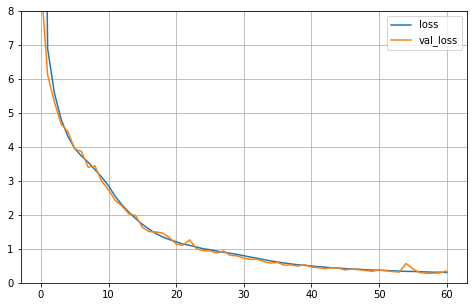

In [13]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,8)
plt.show()

Once you are satisfied with your models validation loss, you should evaluate it on the test set to estimate the generalization error before you deploy the model to production.

In [14]:
model.evaluate(X_test,y_test)

625/625 [==============================] - 1s 1ms/step - loss: 0.3614


0.3613740801811218

We show the plot of actual versus model-predicted prices, and see that they are highly accurate.

In [0]:
predictions = model.predict(X_test)

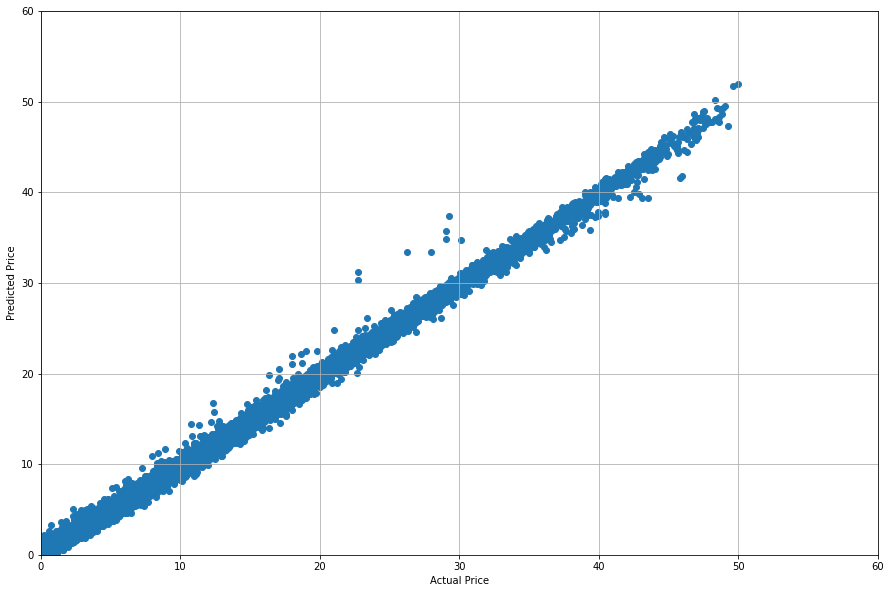

In [16]:
plt.figure(figsize = (15,10))
plt.scatter(y_test, predictions)
ax = plt.gca()
ax.set_ylim([0,60])
ax.set_xlim([0,60])
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)